# **Universidad Icesi - Maestría en Ciencia de Datos**
## Parcial Práctico de Series de Tiempo
## Daniel Martinez & Felipe Montenegro

# **Sección 1 - Librerías**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.ticker as ticker
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.lines as mlines
from matplotlib import rc
import matplotlib as mpl
import pandas as pd
from bayes_opt import BayesianOptimization
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# **Sección 2 - Lectura de Datos**

In [2]:
data = pd.read_csv("Examen.csv")
data.head()

,Unnamed: 0,producto1,producto2
0,1,4000.000000,3000.000000
1,2,3997.400893,3010.686220
2,3,3978.605317,3022.018584
3,4,3986.454125,3033.920990
4,5,3979.695678,3038.402098


# **Sección 3 - Análisis Descriptivo**

Teniendo en cuenta que no tenemos la variable tiempo, es necesario modificar la colmna "Unnamed" y definir la fecha de inicio de la serie.

In [3]:
# Cargar el dataset
data = pd.read_csv('Examen.csv')

# Renombrar la columna 'Unnamed: 0' a 'Mes'
data.rename(columns={'Unnamed: 0': 'Mes'}, inplace=True)

# Crear una serie de fechas a partir de enero de 2008, asignándolas a la columna 'Mes'
data['Mes'] = pd.date_range(start='2008-01-01', periods=len(data), freq='MS')

# Mostrar los primeros datos para verificar
print(data.head())

# Guardar el nuevo dataset con la columna de "Mes"
data.to_csv('Examen2.csv', index=False)


         Mes    producto1    producto2
0 2008-01-01  4000.000000  3000.000000
1 2008-02-01  3997.400893  3010.686220
2 2008-03-01  3978.605317  3022.018584
3 2008-04-01  3986.454125  3033.920990
4 2008-05-01  3979.695678  3038.402098


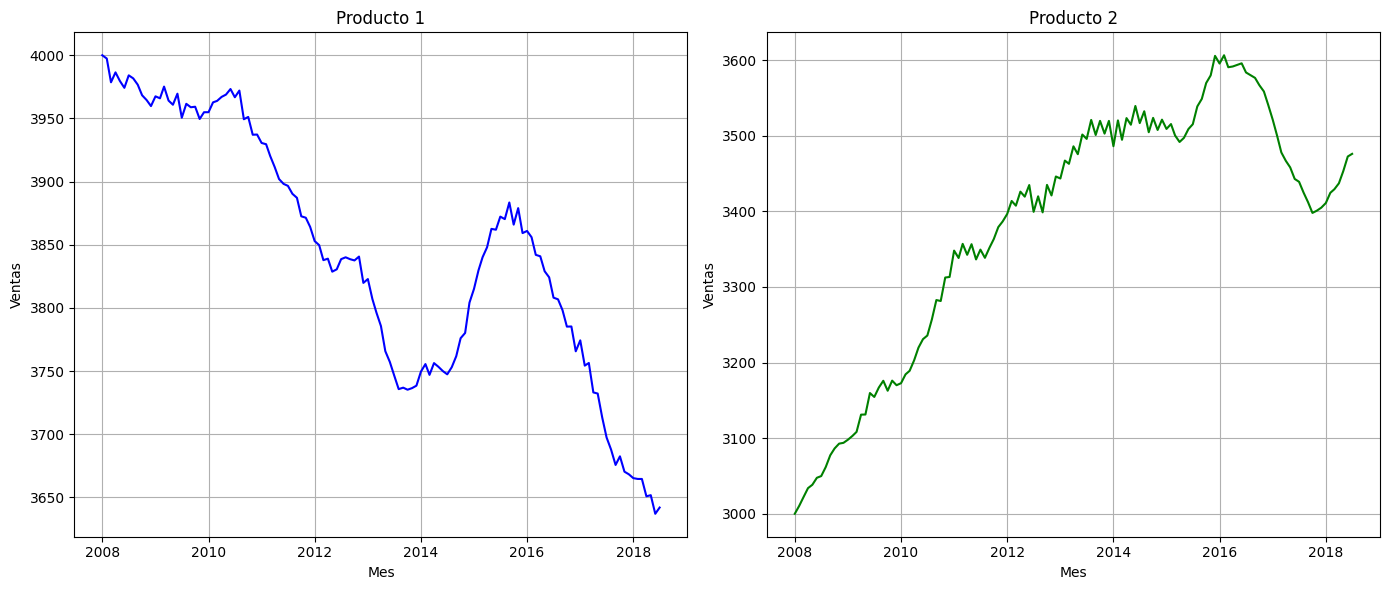

In [4]:
# Convertir la columna 'Mes' a tipo datetime si no lo está
data['Mes'] = pd.to_datetime(data['Mes'])

# Crear una figura con dos subplots (uno para cada producto)
plt.figure(figsize=(14, 6))

# Gráfico para producto 1
plt.subplot(1, 2, 1)
plt.plot(data['Mes'], data['producto1'], color='blue')  # Eliminamos marker='o'
plt.title('Producto 1')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.grid(True)

# Gráfico para producto 2
plt.subplot(1, 2, 2)
plt.plot(data['Mes'], data['producto2'], color='green')  # Eliminamos marker='o'
plt.title('Producto 2')
plt.xlabel('Mes')
plt.ylabel('Ventas')
plt.grid(True)

# Ajustar el layout para que los subplots no se solapen
plt.tight_layout()

# Mostrar las gráficas
plt.show()


### **Componentes de las series de tiempo**

In [5]:
product_1_df = data[['producto1']]
product_1_df.index = data['Mes']
# --------------------------------------
product_2_df = data[['producto2']]
product_2_df.index = data['Mes']



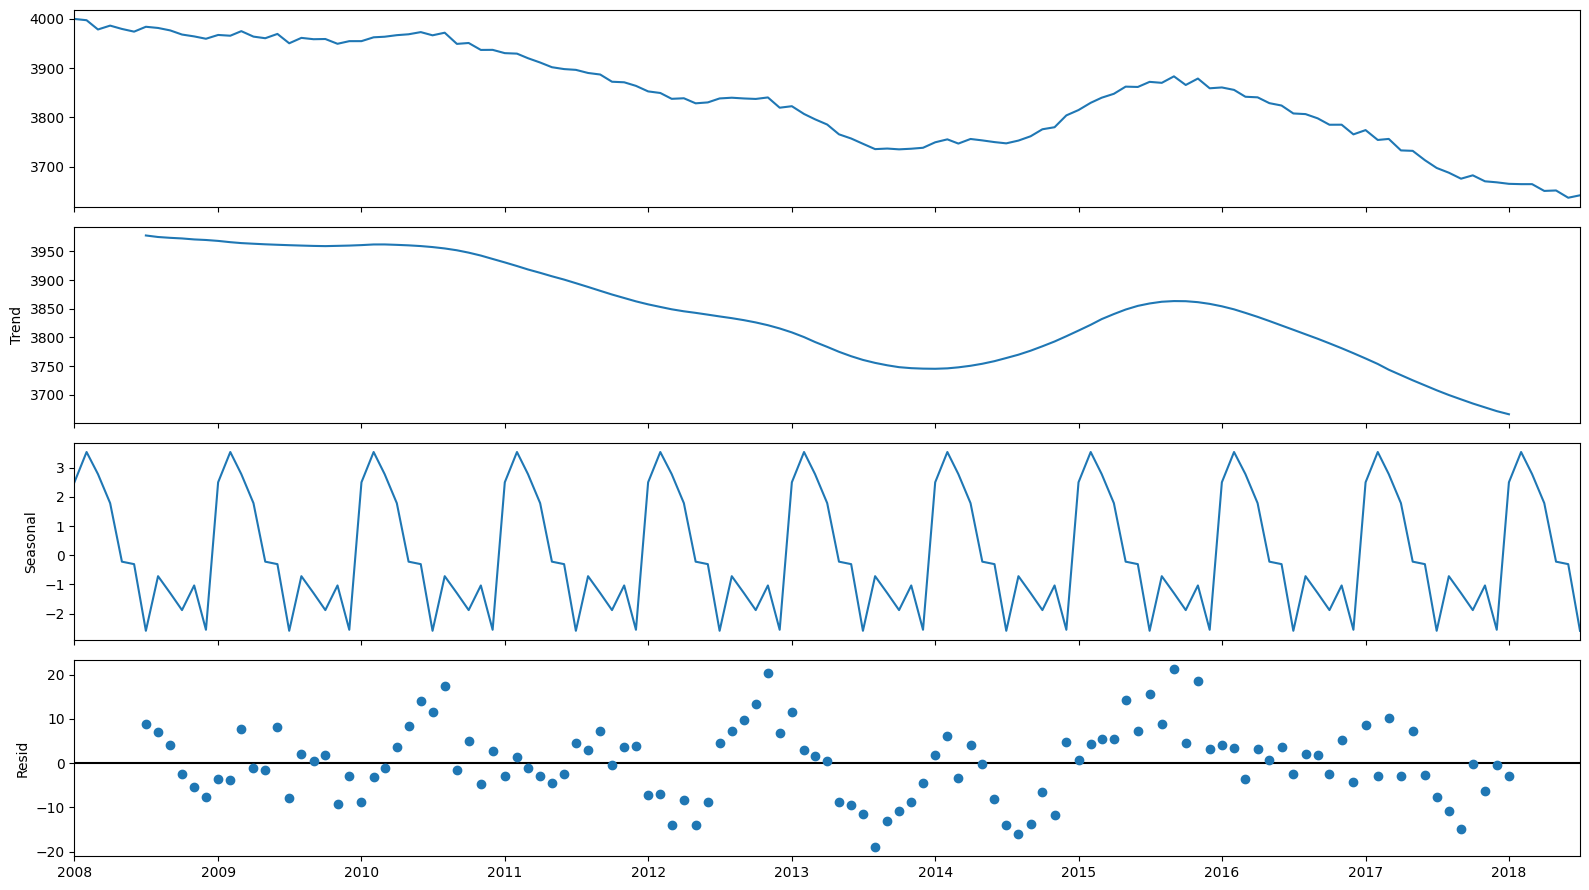

In [6]:
td_componentes = seasonal_decompose(product_1_df,model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

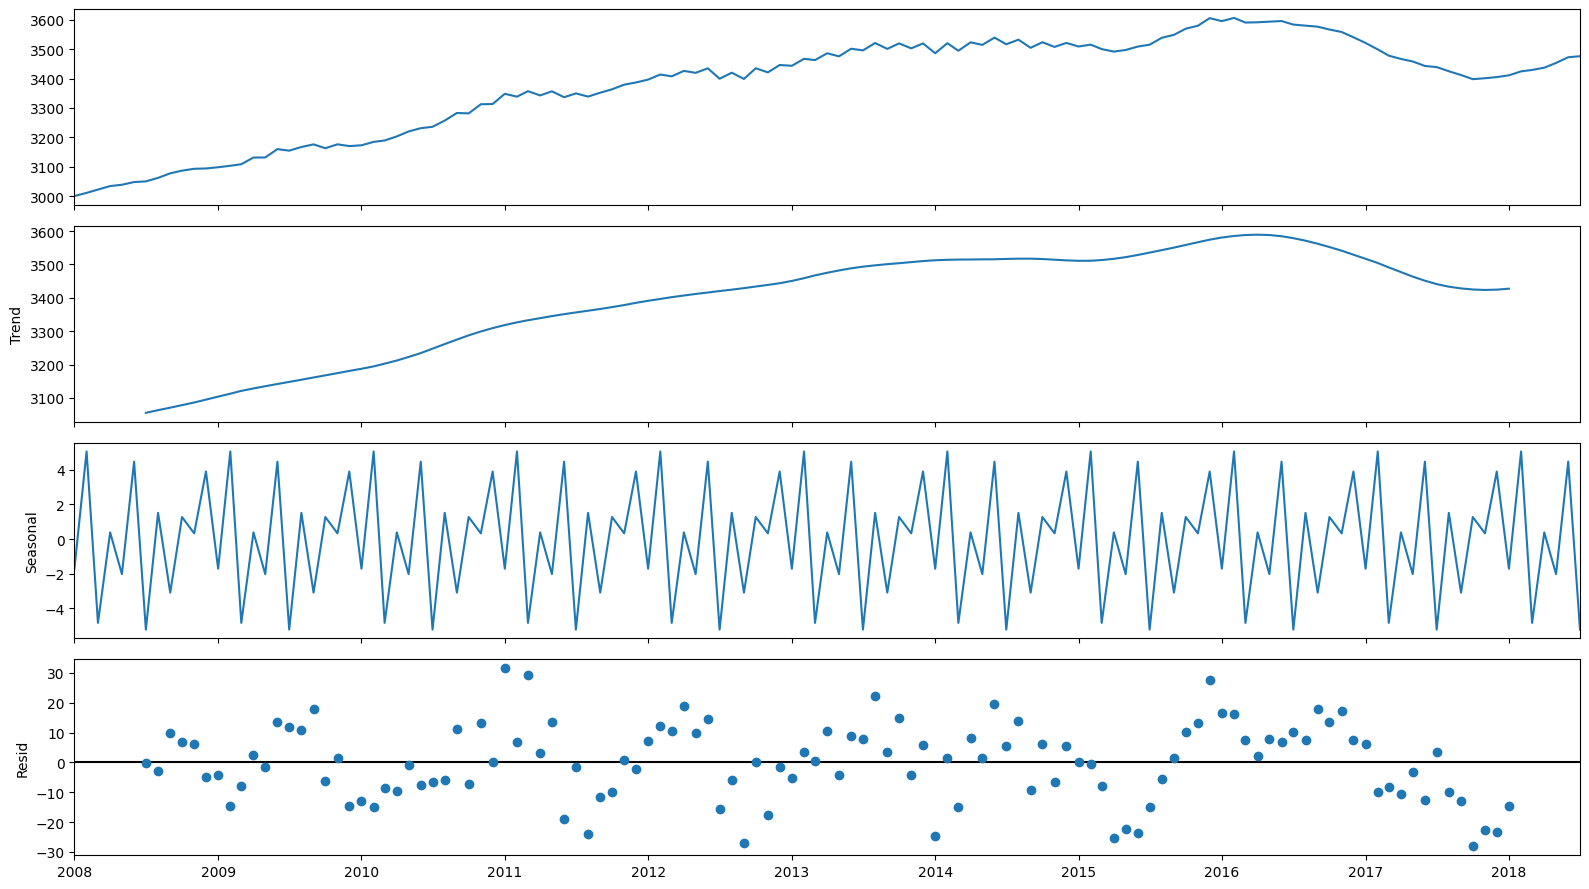

In [7]:
td_componentes = seasonal_decompose(product_2_df,model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

# **Sección 4 - Protocólo de Evaluación**

### Configuración global
- Iteraciones: 10
- Predicción: 1

In [8]:
iterations = 10
train_size = data.shape[0] - iterations
horizon = 1

### Función Protocolo de Evaluación - Ventana Móvil

In [9]:
import pandas as pd
from sklearn.metrics import mean_squared_error

def rolling_window_evaluation(
    model_class,
    data,
    target_column,
    initial_train_size,
    num_iterations,
    forecast_horizon=1,
    init_args=None,
    fit_args=None
):
    test_errors = []
    forecasts = []
    
    best_model = None
    lowest_error = float('inf')

    # Ensure init_args and fit_args are dictionaries
    if init_args is None:
        init_args = {}
    if fit_args is None:
        fit_args = {}

    for i in range(num_iterations):
        train_window = data.iloc[i:i + initial_train_size]
        test_window = data.iloc[i + initial_train_size:i + initial_train_size + forecast_horizon]

        y_train = train_window[target_column]
        y_test = test_window[target_column]

        # Instantiate the model with provided init_args
        model = model_class(y_train, **init_args)

        # Fit the model with fit_args if provided
        model_fit = model.fit(**fit_args)

        # Forecast the next point(s)
        test_predictions = model_fit.forecast(forecast_horizon)
        forecasts.append(test_predictions.iloc[0])  # Storing the first forecast value

        # Calculate the test error
        test_error = mean_squared_error(y_test, test_predictions)
        test_errors.append(test_error)

        # Check if this model has the lowest error and store it
        if test_error < lowest_error:
            lowest_error = test_error
            best_model = model_fit

    return test_errors, forecasts, best_model


### Función para graficar los valores predichos

In [10]:
import matplotlib.pyplot as plt

def plot_forecast(data, forecasts, train_size):
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    
    # Full plot with highlighted forecast section
    ax[0].plot(data.index, data, label='Actual Data', color='blue')
    forecast_indices = range(train_size, train_size + len(forecasts))
    ax[0].plot(forecast_indices, forecasts, label='Forecast', color='orange')
    ax[0].axvspan(train_size, train_size + len(forecasts), color='gray', alpha=0.3)
    ax[0].set_title('Actual Data with Forecast Overlay')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('Value')
    ax[0].legend()
    ax[0].grid(True)

    # Zoomed-in section on forecast
    ax[1].plot(forecast_indices, data[train_size:train_size + len(forecasts)], label='Actual Data (Zoomed)', color='blue', marker='o')
    ax[1].plot(forecast_indices, forecasts, label='Forecast (Zoomed)', color='orange', marker='o')

    # Adding subtle lines to indicate the delta between actual and forecast
    for i in range(len(forecasts)):
        ax[1].plot([forecast_indices[i], forecast_indices[i]], [data[train_size + i], forecasts[i]], color='red', linestyle='--', linewidth=2)

    ax[1].set_title('Zoomed-In Forecast Section with Delta Lines')
    ax[1].set_xlabel('Time')
    ax[1].set_ylabel('Value')
    ax[1].legend()
    ax[1].grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()


# **Sección 5 - Desarrollo de Modelos**

## **Despligue para Producto 1**

### 5.1 Promedio Móvil

In [11]:
import pandas as pd
import numpy as np

class MovingAverageModel:
    def __init__(self, endog, window):
        self.endog = endog
        self.window = window
        self.fittedvalues = None

    def fit(self):
        self.fittedvalues = self.endog.rolling(window=self.window).mean().dropna()
        return self

    def forecast(self, steps):
        last_window = self.endog.iloc[-self.window:]
        forecast_values = np.full(steps, last_window.mean())
        return pd.Series(forecast_values, index=pd.RangeIndex(start=len(self.endog), stop=len(self.endog) + steps))


moving_average_test_errors, moving_average_forecasts, moving_average_model = rolling_window_evaluation(
    model_class=MovingAverageModel,
    data=data,
    target_column='producto1',
    initial_train_size=train_size,
    num_iterations=iterations,
    forecast_horizon=horizon,
    init_args={
        'window': 3
	}
)

moving_average_rmse = np.sqrt(np.mean(moving_average_test_errors))
print(f"Promedio móvil RMSE: {moving_average_rmse}")
print(moving_average_model)


Promedio móvil RMSE: 9.680204135597737


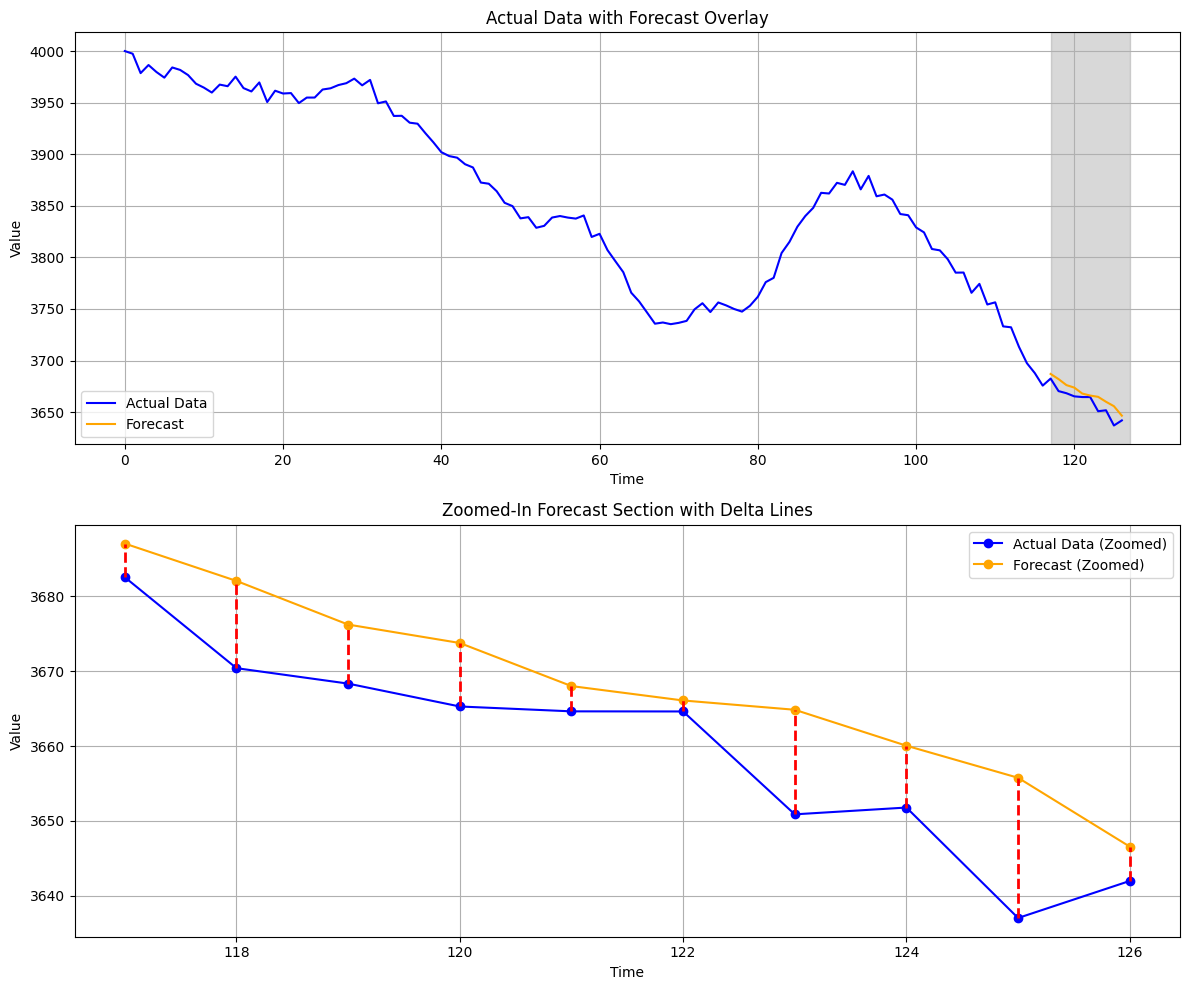

In [12]:
plot_forecast(data['producto1'], moving_average_forecasts, train_size)

## **5.2 Suavización Exponencial Holt Winters**

Con el objetivo de encontrar o más bien seleccionar los mejores hiperparámetros, llevaremos a cabo la aplicación de la técnica **Optimización Bayesiana**

In [13]:
# Buscando facilitar el uso de la técnica de optimización bayesiana procedemos a separar el dataset según el producto a utilizar:

# Crear el dataset con 'Mes' y 'producto1'
data_producto1 = data[['Mes', 'producto1']].set_index('Mes')

# Crear el dataset con 'Mes' y 'producto2'
data_producto2 = data[['Mes', 'producto2']].set_index('Mes')

#Frecuencia
data_producto1.index = pd.to_datetime(data_producto1.index)
data_producto1 = data_producto1.asfreq('MS')  # Mes

data_producto2.index = pd.to_datetime(data_producto2.index)
data_producto2 = data_producto2.asfreq('MS')  # Mes

# Mostrar los primeros datos para verificar
print(data_producto1.head())
print(data_producto2.head())


              producto1
Mes                    
2008-01-01  4000.000000
2008-02-01  3997.400893
2008-03-01  3978.605317
2008-04-01  3986.454125
2008-05-01  3979.695678
              producto2
Mes                    
2008-01-01  3000.000000
2008-02-01  3010.686220
2008-03-01  3022.018584
2008-04-01  3033.920990
2008-05-01  3038.402098


In [14]:
def train_and_evaluate_RMSE_bayes(error, trend, seasonal, alpha, beta, gamma):
    """Function we want to maximize (Black box)"""

    train_data = data_producto1[:len(data_producto1)-10]
    test_data = data_producto1[len(data_producto1)-10:len(data_producto1)]

    alpha = round(alpha, 2)
    beta = round(beta, 2)
    gamma = round(gamma, 2)

    error1 = ["add", "mul"]
    trend1 = ["add", "mul", None]
    seasonal1 = ["add", "mul", None]

    # Asegúrate de que el índice tenga una frecuencia definida
    if train_data.index.freq is None:
        train_data = train_data.asfreq('D')  # Ajusta 'D' a la frecuencia que corresponda

    model = ETSModel(
        endog=train_data[train_data.columns[0]],
        error=error1[round(error)],
        trend=trend1[round(trend)],
        seasonal=seasonal1[round(seasonal)],
        seasonal_periods=12  # Ajusta según sea necesario
    )

    params = {'smoothing_level': alpha, 'smoothing_trend': beta, 'smoothing_seasonal': gamma}

    if trend1[round(trend)] is None:
        params.pop('smoothing_trend')
    if seasonal1[round(seasonal)] is None:
        params.pop('smoothing_seasonal')

    model_result = model.fit_constrained(params)

    point_forecast = model_result.forecast(10)
    rmse = np.sqrt(mean_squared_error(test_data, point_forecast))

    print(f"target es: {rmse}, Error test: {error1[round(error)]}, Trend test: {trend1[round(trend)]}, Seasonal test: {seasonal1[round(seasonal)]}, Alpha model: {alpha}, Beta model: {beta}, Gamma model: {gamma}")

    return -rmse


In [15]:
pbounds = {'error':  (0,1),'trend':(0,2) , 'seasonal': (0,2), 'alpha':(0.01,0.99) , "beta" :(0.01,0.99),"gamma" :(0.01,0.99) }

In [16]:
optimizer = BayesianOptimization(
    f=train_and_evaluate_RMSE_bayes,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

In [17]:
import warnings
warnings.filterwarnings("ignore")
optimizer.maximize(init_points=3, n_iter=100)

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------
target es: 72.48737026802618, Error test: add, Trend test: add, Seasonal test: add, Alpha model: 0.42, Beta model: 0.72, Gamma model: 0.31
| 1         | -72.49    | 0.4187    | 0.7159    | 0.0001144 | 0.3063    | 0.2935    | 0.1847    |
target es: 60.641442100971744, Error test: add, Trend test: mul, Seasonal test: mul, Alpha model: 0.19, Beta model: 0.35, Gamma model: 0.54
| 2         | -60.64    | 0.1925    | 0.3486    | 0.3968    | 0.538     | 0.8384    | 1.37      |
target es: 186.1726399076884, Error test: add, Trend test: mul, Seasonal test: mul, Alpha model: 0.21, Beta model: 0.87, Gamma model: 0.67
| 3         | -186.2    | 0.2104    | 0.8706    | 0.02739   | 0.6671    | 0.8346    | 1.117     |
target es: 54.32002028801925, Error test: add, Trend test: add, Seasonal test: None, Alpha m

In [18]:
optimizer.max

{'target': -6.024658946493644,
 'params': {'alpha': 0.30195246569030304,
  'beta': 0.01,
  'error': 0.0,
  'gamma': 0.7876834379173638,
  'seasonal': 1.2950770402008143,
  'trend': 1.1477609700925209}}

In [19]:
values_map = {0: None, 1: "add", 2: "mul"}

data_copy = data.copy()
data_copy['Mes'] = pd.to_datetime(data_copy['Mes'])
data_copy = data_copy.set_index('Mes')
data_copy = data_copy.asfreq('MS')

init_args = {
    'error': values_map[round(optimizer.max['params']['error'])],
    'trend': values_map[round(optimizer.max['params']['trend'])],
    'seasonal': values_map[round(optimizer.max['params']['seasonal'])],
}

fit_args = {
    'smoothing_level': optimizer.max['params']['alpha'],
    'smoothing_trend': optimizer.max['params']['beta'] if init_args['trend'] else None,
    'smoothing_seasonal': optimizer.max['params']['gamma'] if init_args['seasonal'] else None
}

filtered_init = {k: v for k, v in init_args.items() if v is not None}
filtered_fit = {k: v for k, v in fit_args.items() if v is not None}

test_errors, forecasts, best_model = rolling_window_evaluation(
    model_class=ETSModel,
    data=data_copy,
    target_column='producto1',
    initial_train_size=train_size,
    num_iterations=iterations,
    forecast_horizon=horizon,
    init_args=filtered_init,
    fit_args=filtered_fit
)

In [20]:
print(f'Best Model: {best_model}')
print(f'Test Errors: {test_errors}')
print(f'Forecasts: {forecasts}')
# rmse
rmse = np.sqrt(np.mean(test_errors))
print(f'RMSE: {rmse}')

Best Model: <statsmodels.tsa.exponential_smoothing.ets.ETSResultsWrapper object at 0x000001E65B115A50>
Test Errors: [575.4117082738697, 0.3537095704644192, 2.2198548931661657, 43.312340798627226, 0.001893404733247347, 28.234049110324822, 66.45060704637626, 23.218951491818498, 74.46382030213374, 137.18884396572344]
Forecasts: [3658.5385156852917, 3670.984736121635, 3666.838507350176, 3671.8558107381627, 3664.668984963572, 3659.297198964694, 3659.033563501374, 3646.969864915812, 3645.6768815754376, 3630.2781085248243]
RMSE: 9.751183409500806


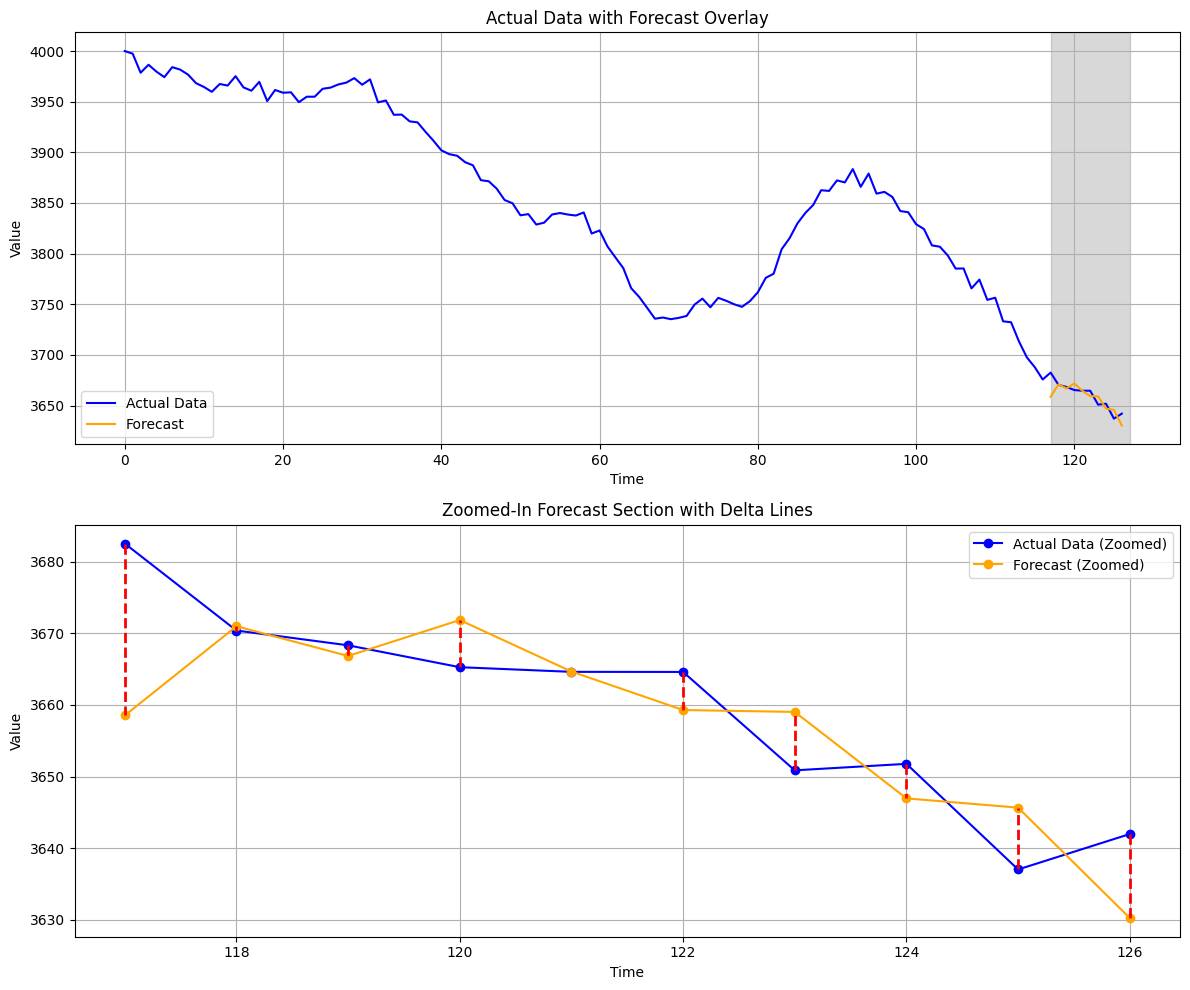

In [21]:
plot_forecast(data['producto1'], forecasts, train_size)

## **5.3 Modelos de Regresión (Tendencia y Estacionalidad)**

Esta función ajusta un modelo de regresión polinómica de un orden especificado sobre un conjunto de datos de entrenamiento. Luego, realiza un pronóstico para un horizonte de tiempo determinado y calcula el RMSE comparando los valores predichos con los valores reales del conjunto de prueba.

In [22]:
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

def fit_polynomial_model(order, y_train, y_test, forecast_horizon):
    # Definir las variables independientes (X) y dependientes (y)
    x_train = np.linspace(1, len(y_train), len(y_train))
    X_train = np.vander(x_train, N=order+1, increasing=True)
    
    # Ajustar el modelo de regresión polinómica
    model = sm.OLS(y_train, X_train)
    model_fit = model.fit()

    # Generar pronósticos para el horizonte especificado
    x_for = np.linspace(len(y_train) + 1, len(y_train) + forecast_horizon, forecast_horizon)
    X_for = np.vander(x_for, N=order+1, increasing=True)
    dt = model_fit.get_prediction(X_for).summary_frame(alpha=0.05)
    y_prd = dt['mean']
    
    # Calcular el RMSE entre los valores pronosticados y los valores reales
    rmse = np.sqrt(mean_squared_error(y_test, y_prd))

    return model_fit, y_prd, rmse, dt


Aquí, se implemnta una función que realiza la evaluación del modelo utilizando el protocolo de ventana móvil. Itera sobre diferentes ventanas de tiempo, ajusta un modelo de regresión polinómica en cada una, y selecciona el mejor modelo basado en el RMSE más bajo. Al final, se generan las visualizaciones y tablas solo para el mejor modelo.

In [23]:
def rolling_window_evaluation_poly(
    data,
    target_column,
    initial_train_size,
    num_iterations,
    forecast_horizon=1,
    order=1
):
    test_errors = []
    forecasts = []
    all_rmses = []
    
    best_model_summary = None
    lowest_error = float('inf')

    for i in range(num_iterations):
        # Crear las ventanas de entrenamiento y prueba
        train_window = data.iloc[i:i + initial_train_size]
        test_window = data.iloc[i + initial_train_size:i + initial_train_size + forecast_horizon]

        y_train = train_window[target_column]
        y_test = test_window[target_column]

        # Ajustar el modelo y obtener los pronósticos y errores
        model_fit, test_predictions, test_error, dt = fit_polynomial_model(order, y_train, y_test, forecast_horizon)
        
        forecasts.append(test_predictions.iloc[0])  # Guardar la primera predicción
        test_errors.append(test_error)
        all_rmses.append(test_error)

        # Guardar el mejor modelo si tiene el menor error
        if test_error < lowest_error:
            lowest_error = test_error
            best_model_summary = {
                "model": model_fit,
                "y_train": y_train,
                "residuals": model_fit.resid,
                "fitted_values": model_fit.fittedvalues,
                "predictions": dt,
                "rmse": test_error,
                "forecast_horizon": forecast_horizon
            }
    
    # Devolver los resultados y el mejor modelo encontrado
    return test_errors, forecasts, best_model_summary


Esta parte del código se encarga de generar y mostrar las visualizaciones y tablas para el mejor modelo encontrado durante la evaluación. Incluye gráficos de residuos, tendencias, pronósticos, un zoom en los últimos 5 meses, y un resumen de los RMSE de todas las iteraciones.

In [24]:
def display_results(best_model_summary, all_rmses):
    # Gráfica de los residuos del mejor modelo
    print("Residuos del mejor modelo:")
    plt.figure(figsize=(10, 6))
    plt.title("Residuos del modelo")
    plt.plot(best_model_summary['y_train'].index, best_model_summary['residuals'])  # Aquí graficamos los residuos reales
    plt.ylabel("Residuales del modelo")
    plt.grid()
    plt.show()
    
    # Gráfica de la serie original y la tendencia ajustada
    print("Serie original y tendencia ajustada:")
    plt.figure(figsize=(10, 6))
    plt.plot(best_model_summary['y_train'], label="Datos de Entrenamiento")
    plt.plot(best_model_summary['fitted_values'], label=f"Tendencia de Orden")
    plt.legend()
    plt.grid()
    plt.show()

    # Tabla de los pronósticos e intervalos de confianza
    print(f"Pronóstico para los próximos {best_model_summary['forecast_horizon']} periodos:")
    preds = pd.DataFrame({
        'Point_forecast': best_model_summary['predictions']['mean'],
        'Lower_95': best_model_summary['predictions']['obs_ci_lower'],
        'Upper_95': best_model_summary['predictions']['obs_ci_upper']
    })
    print(preds)

    # Gráfica de la serie original y el pronóstico estimado
    print(f"Serie original y pronóstico estimado para los próximos {best_model_summary['forecast_horizon']} periodos:")
    plt.figure(figsize=(12, 6))
    x_for = np.linspace(len(best_model_summary['y_train']) + 1, len(best_model_summary['y_train']) + best_model_summary['forecast_horizon'], best_model_summary['forecast_horizon'])
    plt.plot(np.linspace(1, len(best_model_summary['y_train']), len(best_model_summary['y_train'])), best_model_summary['y_train'], label="Datos de Entrenamiento")
    plt.plot(x_for, best_model_summary['predictions']['mean'], label="Pronóstico")
    plt.fill_between(x_for, best_model_summary['predictions']['obs_ci_lower'], best_model_summary['predictions']['obs_ci_upper'], color='blue', alpha=0.1)
    plt.legend()
    plt.grid()
    plt.show()

    # Gráfica de zoom en los últimos 5 meses
    print("Zoom en los últimos 5 meses:")
    plt.figure(figsize=(12, 6))
    plt.plot(best_model_summary['y_train'][-5:], label="Datos de Entrenamiento (Últimos 5 meses)")
    plt.plot(x_for, best_model_summary['predictions']['mean'], label="Pronóstico")
    plt.fill_between(x_for, best_model_summary['predictions']['obs_ci_lower'], best_model_summary['predictions']['obs_ci_upper'], color='blue', alpha=0.1)
    plt.legend()
    plt.grid()
    plt.show()

    # Resumen de RMSE de cada modelo
    print("Resumen de RMSE por modelo:")
    for i, rmse in enumerate(all_rmses):
        if rmse == best_model_summary['rmse']:
            print(f"Iteración {i+1}: RMSE = {rmse} <- Mejor modelo")
        else:
            print(f"Iteración {i+1}: RMSE = {rmse}")

Aquí se ejecuta el proceso completo, desde la evaluación de los modelos hasta la visualización de los resultados del mejor modelo encontrado. Primero, ejecutamos la función de evaluación y luego mostramos los resultados.

### Modelo con Tendencia Cuadrática

Residuos del mejor modelo:


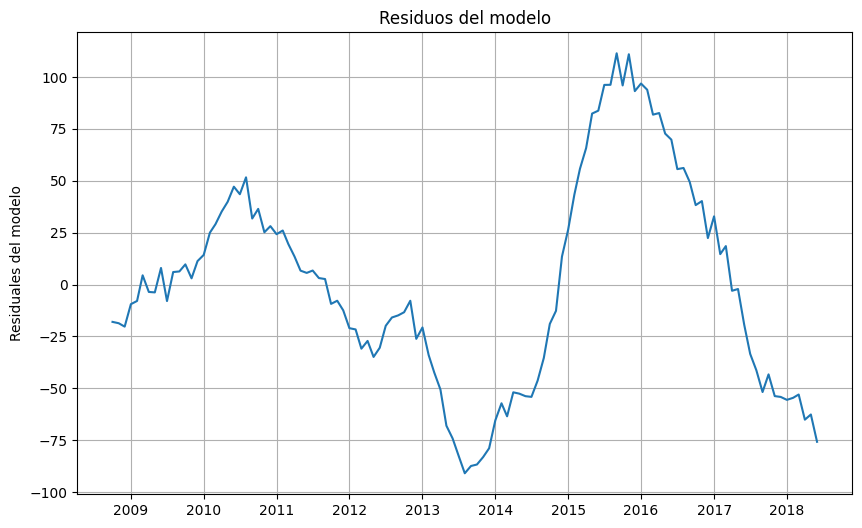

Serie original y tendencia ajustada:


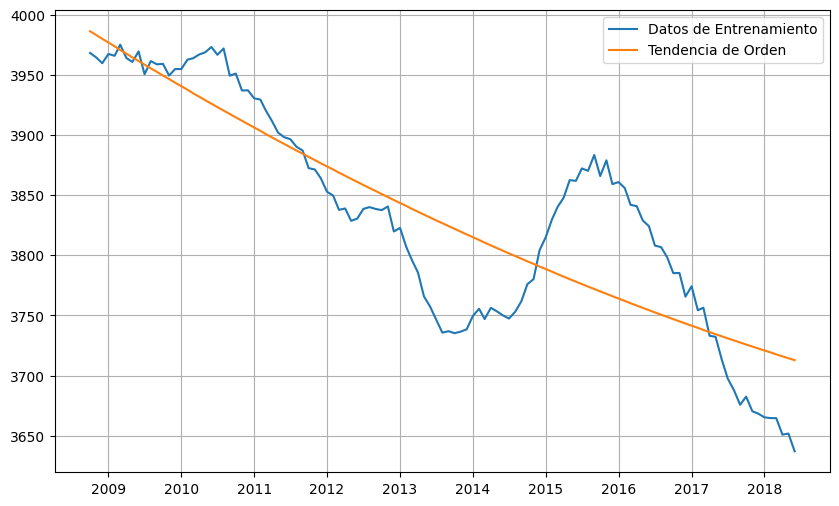

Pronóstico para los próximos 1 periodos:
   Point_forecast     Lower_95     Upper_95
0     3711.295501  3607.620295  3814.970706
Serie original y pronóstico estimado para los próximos 1 periodos:


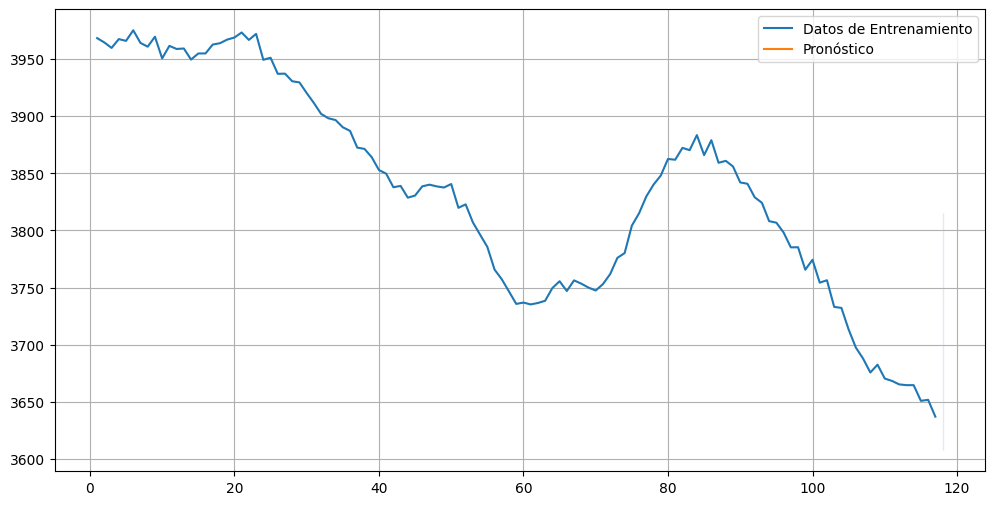

Zoom en los últimos 5 meses:


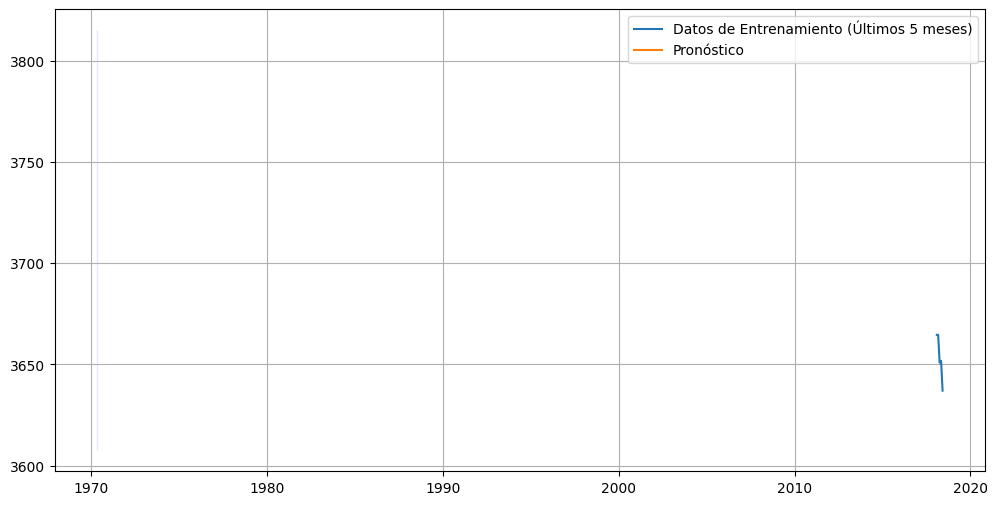

Resumen de RMSE por modelo:
Iteración 1: RMSE = 87.76447218123394
Iteración 2: RMSE = 93.56651033743083
Iteración 3: RMSE = 88.64084747948436
Iteración 4: RMSE = 85.29872827057443
Iteración 5: RMSE = 79.36312810283926
Iteración 6: RMSE = 73.17192109993948
Iteración 7: RMSE = 81.08913607449676
Iteración 8: RMSE = 73.28662150354648
Iteración 9: RMSE = 81.51681533972078
Iteración 10: RMSE = 69.3046278439756 <- Mejor modelo


In [25]:
# Ejecutar el proceso de evaluación con ventana móvil
test_errors, forecasts, best_model_summary = rolling_window_evaluation_poly(
    data=data_copy,
    target_column='producto1',
    initial_train_size=train_size,
    num_iterations=iterations,
    forecast_horizon=horizon,
    order=2  
)

# Mostrar los resultados del mejor modelo encontrado
display_results(best_model_summary, test_errors)